# Goal

- The goal of this notebook is to consduct LDA Topic modeling on the positive and negative reviews for the 
world of tanks blitz

In [2]:
# reading the DS
import pandas as pd
df= pd.read_csv('Mid_DS_NLP.csv')

In [3]:
print('size of df berfore removing duplicates: ', df.shape)

size of df berfore removing duplicates:  (1769732, 5)


In [4]:
# check if there any duplicated review in df['review'] and count them
df[df['review'].duplicated()]
# print the precentage of duplicated reviews
print('the precentage of duplicated reviews is', df[df['review'].duplicated()].shape[0]/df.shape[0]*100)

the precentage of duplicated reviews is 14.04958490890146


In [5]:
# drop the duplicated reviews
df.drop_duplicates(subset=['review'], inplace=True)

In [6]:
print('size of df after removing duplicates: ', df.shape)

size of df after removing duplicates:  (1521092, 5)


In [7]:
#NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [8]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [9]:
# selecting only World of Tanks Blitz reviews
wotb_df= df[df['app_name']=='World of Tanks Blitz']

In [10]:
# Function to classify sentiment based on player ratings
def classify_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

# Apply sentiment analysis to the reviews
wotb_df['sentiment'] = wotb_df['rating'].apply(classify_sentiment)

/var/folders/tq/4lg57j0x7j394cz4rt750tsr0000gn/T/ipykernel_1698/1104402309.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wotb_df['sentiment'] = wotb_df['rating'].apply(classify_sentiment)


In [11]:
pos_wotb_df= wotb_df[wotb_df['sentiment']=='positive']
neg_wotb_df= wotb_df[wotb_df['sentiment']=='negative']
neu_wotb_df= wotb_df[wotb_df['sentiment']=='neutral']

In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts, bigram_mod, trigram_mod):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 
def lemmatization(texts, nlp= nlp, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [68]:
def preprocessing(df):
    # Convert to list
    data = df.review.values.tolist()

    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

    data =  list(sent_to_words(data))
    bigram = gensim.models.Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    data_words_nostops = remove_stopwords(data)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops, bigram_mod)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)

    print('lemmatization started')
    print(len(data_words_bigrams))
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]



- cleaning the reviews 

In [69]:
pos_txt, pos_corp, pos_id2w = preprocessing(pos_wotb_df)
neg_txt, neg_corp, neg_id2w = preprocessing(neg_wotb_df)
neu_txt, neu_corp, neu_id2w = preprocessing(neu_wotb_df)


lemmatization started
24545
lemmatization started
13833
lemmatization started
4152


In [75]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           alpha='auto',
                                           per_word_topics=True,
                                           )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [76]:
# will take a long time to run.
pos_model_list, pos_coherence_values = compute_coherence_values(dictionary=pos_id2w, corpus=pos_corp, texts=pos_txt, start=2, limit=10, step=3)

In [80]:
# will take a long time to run.
neg_model_list, neg_coherence_values = compute_coherence_values(dictionary=neg_id2w, corpus=neg_corp, texts=neg_txt, start=2, limit=10, step=3)

In [ ]:
def plot_graph(coherence_values, start, limit, step):
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

- plotting the graph to show the best number of topcis for LDA model trained on positive reviews

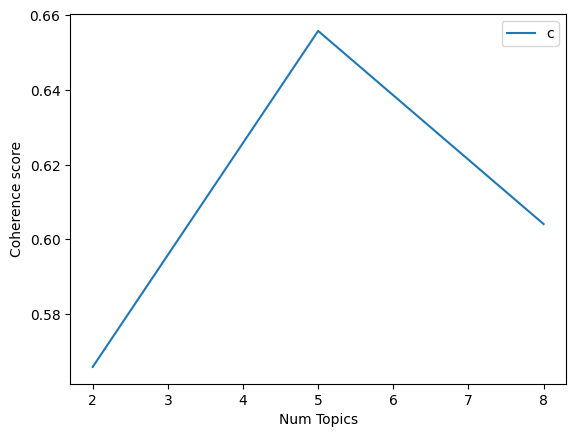

In [81]:
plot_graph(pos_coherence_values, 2, 10, 3)

- plotting the graph to show the best number of topcis for LDA model trained on Negative reviews

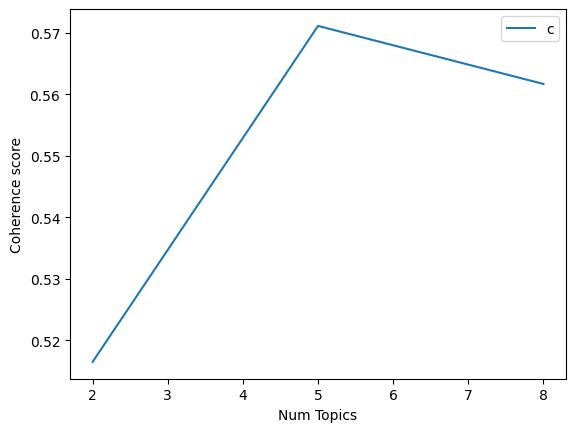

In [82]:
plot_graph(neg_coherence_values, 2, 10, 3)

In [95]:
def visualize_best_model(pos_model_list,corpus, id2word):
    max_index= pos_coherence_values.index(max(pos_coherence_values))
    print(max_index)
    optimal_model = pos_model_list[max_index]
    model_topics = optimal_model.show_topics(formatted=False)
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
    return vis

- Showing the Top topics for LDA model for the positive reviews

In [90]:
vis = visualize_best_model(pos_model_list)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.096368 -0.122370       1        1  50.677289
4     -0.141922  0.031947       2        1  19.652238
1     -0.005764 -0.108370       3        1  12.184638
0     -0.035024  0.201724       4        1  10.213865
3      0.279078 -0.002931       5        1   7.271970, topic_info=          Term          Freq         Total Category  logprob  loglift
24        tank  10798.000000  10798.000000  Default  30.0000  30.0000
144        add   2421.000000   2421.000000  Default  29.0000  29.0000
70      update   2869.000000   2869.000000  Default  28.0000  28.0000
67         fix   1685.000000   1685.000000  Default  27.0000  27.0000
21         get   4099.000000   4099.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
86         new    194.481055   2011.400870   Topic5  -4.6504   0.2849
309  developer    133.243536    539.871304   Topic5  -5.0286   1.2220
548       hope    126.300302    744.594074   Topic5  -5.0821   0.8470
166       lose    120.257558    558.208351   Topic5  -5.1311   1.0860
211          s    122.672080    919.791635   Topic5  -5.1112   0.6065

[419 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
592       1  0.029987  accidentally
592       5  0.959594  accidentally
174       1  0.139309       account
174       2  0.008392       account
174       3  0.370932       account
...     ...       ...           ...
40        2  0.035168          year
40        3  0.106938          year
40        4  0.017943          year
40        5  0.001435          year
3580      5  0.966870     yesterday

[952 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 1, 4])

- Showing the Top topics for the LDA for the negative reviews

In [96]:
vis = visualize_best_model(neg_model_list, neg_corp, neg_id2w)
vis

1


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.072911  0.004752       1        1  24.939410
1     -0.067729  0.052981       2        1  22.879592
2     -0.087746  0.000946       3        1  21.850748
3      0.168730  0.068929       4        1  19.072720
4      0.059656 -0.127608       5        1  11.257531, topic_info=        Term         Freq        Total Category  logprob  loglift
83    update  2214.000000  2214.000000  Default  30.0000  30.0000
93      tank  5295.000000  5295.000000  Default  29.0000  29.0000
28    server  2122.000000  2122.000000  Default  28.0000  28.0000
10   connect  1065.000000  1065.000000  Default  27.0000  27.0000
16       fix  2395.000000  2395.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
28    server   167.907854  2122.327646   Topic5  -5.0086  -0.3527
128     make   168.629370  2379.034463   Topic5  -5.0043  -0.4626
24    player   165.678045  3118.246422   Topic5  -5.0219  -0.7508
14      even   144.455681  1869.496342   Topic5  -5.1590  -0.3763
156     time   139.708683  2177.825555   Topic5  -5.1924  -0.5624

[439 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
5174      5  0.928647  absolute_disgrace
2499      2  0.027696             accept
2499      4  0.941670             accept
1671      1  0.039681             access
1671      2  0.019840             access
...     ...       ...                ...
84        1  0.611261               year
84        2  0.078258               year
84        3  0.074028               year
84        4  0.132193               year
84        5  0.104697               year

[1000 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

- extracting the dominant topcis for each sentence based on the topic with the highest contibution

In [49]:
# def format_topics_sentences(ldamodel, corpus=corpus, texts=data):
#     # Init output
#     sent_topics_df = pd.DataFrame()

#     # Get main topic in each document
#     for i, row in enumerate(ldamodel[corpus]):
#         row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
#         # Get the Dominant topic, Perc Contribution and Keywords for each document
#         for j, (topic_num, prop_topic) in enumerate(row):
#             if j == 0:  # => dominant topic
#                 wp = ldamodel.show_topic(topic_num)
#                 topic_keywords = ", ".join([word for word, prop in wp])
#                 new_row = pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords])
#                 sent_topics_df = pd.concat([sent_topics_df, new_row.to_frame().T], ignore_index=True)

#                 #sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
#                 #sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
#             else:
#                 break
#     sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

#     # Add original text to the end of the output
#     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
#     return(sent_topics_df)


# df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)


In [81]:
# sent_topics_df = pd.DataFrame()

# # Get main topic in each document
# for i, row in enumerate(optimal_model[corpus]):
#     row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
#     print(row)
#     # Get the Dominant topic, Perc Contribution and Keywords for each document
#     for j, (topic_num, prop_topic) in enumerate(row):
#         print(topic_num, prop_topic)
#         if j == 0:  # => dominant topic
#             wp = optimal_model.show_topic(topic_num)
#             print(wp)
#             topic_keywords = ", ".join([word for word, prop in wp])
#             new_row = pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords])
#             sent_topics_df = pd.concat([sent_topics_df, new_row.to_frame().T], ignore_index=True)
#             print()
#             break
#     break


[(2, 0.802195), (1, 0.06609361), (3, 0.053537853), (0, 0.042705096), (4, 0.035468448)]
2 0.802195
[('game', 0.14074962), ('good', 0.041121002), ('play', 0.0398993), ('fun', 0.014722215), ('make', 0.013556209), ('tank', 0.013108756), ('player', 0.01307591), ('great', 0.013011234), ('get', 0.01175635), ('really', 0.010704175)]



In [56]:
# # Format
# df_dominant_topic = df_topic_sents_keywords.reset_index()
# df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# # Show
# df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2,0.8022,"game, good, play, fun, make, tank, player, gre...",Very nice game
1,1,2,0.8002,"game, good, play, fun, make, tank, player, gre...",Lets battle
2,2,2,0.9742,"game, good, play, fun, make, tank, player, gre...",This game is very good and nice l am play game...
3,3,2,0.5021,"game, good, play, fun, make, tank, player, gre...",This is a very op game
4,4,3,0.6959,"tank, get, win, tier, pay, money, lose, game, ...",I sold a fury tank by accident havent figured ...
5,5,2,0.4755,"game, good, play, fun, make, tank, player, gre...",Pay to win. Full of cheaters. Not fare teams.
6,6,2,0.8462,"game, good, play, fun, make, tank, player, gre...",Great game just the lag
7,7,1,0.8871,"tank, game, add, love, world, cool, make, awes...",Have enjoyed this game for years. It’s satisfi...
8,8,0,0.4692,"update, server, problem, fix, game, please_fix...",will have a server in Brazil??
9,9,2,0.5643,"game, good, play, fun, make, tank, player, gre...",Great game addictive but one issue wish u coul...


<Axes: >

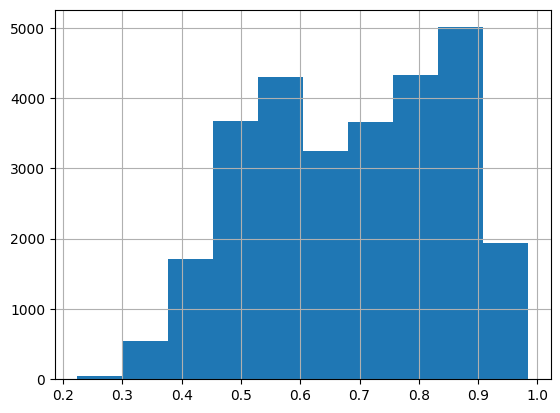

In [55]:
# select the sentence from the dataframe with Perc_Contribution for topic 2 is higher than thr
df_dominant_topic[df_dominant_topic['Dominant_Topic']==2]['Perc_Contribution'].hist()

In [85]:
df_dominant_topic[df_dominant_topic['Topic_Perc_Contrib']>=0.9]['Dominant_Topic'].value_counts()

Dominant_Topic
2    2589
3      25
1      13
0       4
4       1
Name: count, dtype: int64